In [31]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pandas as pd

from utility import get_all_files_paths
from encoder import Encoder, load_encoder
from decoder import Decoder, load_decoder
from train import train_epoch, test_epoch

In [32]:
dataset_path="data/spec/GTZAN_646"
model_save_path="models/Echoes"
csv_save_path="output/Echoes_output"
encoded_space_dim=128

os.makedirs(model_save_path, exist_ok=True)
os.makedirs(csv_save_path, exist_ok=True)

In [33]:
class AudioDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        data = np.load(file_path)
        data = data[np.newaxis, :, :]  # Add a channel dimension
        data = torch.tensor(data, dtype=torch.float32)
        
        # Extract label from file name
        filename = os.path.basename(file_path)
        label_str = filename.split('.')[0]
        label = self.label_to_index(label_str)
        
        return data, label

    @staticmethod
    def label_to_index(label_str):
        label_map = {'blues': 'blues', 'disco': 'disco', 'rock': 'rock', 'metal': 'metal', 'classical': 'classical', 'pop': 'pop', 'reggae':'reggae','country':'country', 'hiphop':'hiphop', 'jazz':'jazz'}  # Extend this as needed
        return label_map.get(label_str, -1)  # Return -1 if label is not found

genres = ['blues', 'disco', 'rock', 'metal', 'pop', 'classical', 'reggae', 'country','hiphop','jazz']

genre_file_paths = {genre: get_all_files_paths(f"{dataset_path}/{genre}", [".npy"]) for genre in genres}

train_file_paths = []
valid_file_paths = []
test_file_paths = []

for genre, paths in genre_file_paths.items():
    m = len(paths)
    test_size = int(m * 0.2)
    valid_size = int((m - test_size) * 0.1)
    train_size = m - test_size - valid_size
    
    paths = np.array(paths)
    np.random.shuffle(paths)
    
    train_paths = paths[:train_size]
    valid_paths = paths[train_size:train_size + valid_size]
    test_paths = paths[train_size + valid_size:]
    
    train_file_paths.extend(train_paths)
    valid_file_paths.extend(valid_paths)
    test_file_paths.extend(test_paths)

train_dataset = AudioDataset(train_file_paths)
valid_dataset = AudioDataset(valid_file_paths)
test_dataset = AudioDataset(test_file_paths)

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(valid_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Training set size: 720
Validation set size: 80
Test set size: 200


In [34]:
### Define an optimizer (both for the encoder and the decoder)
lr= 0.0001
### Set the random seed for reproducible results
torch.manual_seed(0)

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.05, inplace=True)
    (2): Linear(in_features=512, out_features=167936, bias=True)
    (3): LeakyReLU(negative_slope=0.05, inplace=True)
    (4): Dropout(p=0.3, inplace=False)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 16, 41))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 0))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05, inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.05, inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), ou

In [35]:
total_epochs = 100
beta = 1

diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(total_epochs):

	# beta = epoch / total_epochs  # Increase beta over time

	train_loss =train_epoch(encoder,decoder,device,train_loader,optim, beta)
	val_loss = test_epoch(encoder,decoder,device,test_loader, beta)
	print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, total_epochs, train_loss,val_loss))
	diz_loss['train_loss'].append(train_loss)
	diz_loss['val_loss'].append(val_loss)

	if (epoch+1)%10 ==0: 
		torch.save(encoder.state_dict(), f'{model_save_path}/encoder_{epoch+1}.pth')
		torch.save(decoder.state_dict(), f'{model_save_path}/decoder_{epoch+1}.pth')

	# plot_ae_outputs(encoder,decoder,n=10)


 EPOCH 1/100 	 train loss 429.2693176269531 	 val loss 171.73829650878906

 EPOCH 2/100 	 train loss 118.21939086914062 	 val loss 17.658340454101562

 EPOCH 3/100 	 train loss 16.320037841796875 	 val loss 22.43445587158203

 EPOCH 4/100 	 train loss 25.29598045349121 	 val loss 76.3396224975586

 EPOCH 5/100 	 train loss 80.95887756347656 	 val loss 1036.9632568359375

 EPOCH 6/100 	 train loss 182.4568328857422 	 val loss 10257460.0

 EPOCH 7/100 	 train loss 220.04666137695312 	 val loss 20128968.0

 EPOCH 8/100 	 train loss 450.90985107421875 	 val loss 15648893.0

 EPOCH 9/100 	 train loss 1541.8909912109375 	 val loss 3806.337158203125

 EPOCH 10/100 	 train loss 3739.683349609375 	 val loss 142720320.0

 EPOCH 11/100 	 train loss 24092.96484375 	 val loss 5432857.5

 EPOCH 12/100 	 train loss 4285.8125 	 val loss 66557108.0

 EPOCH 13/100 	 train loss 4173.62841796875 	 val loss 31966592.0


KeyboardInterrupt: 

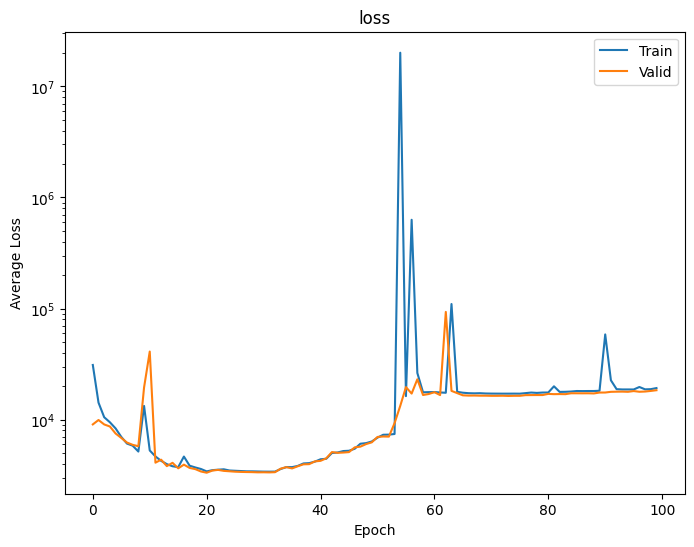

In [11]:
import matplotlib.pyplot as plt
# Plot losses
plt.figure(figsize=(8,6))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
# plt.grid()
plt.legend()
plt.title('loss')
plt.show()

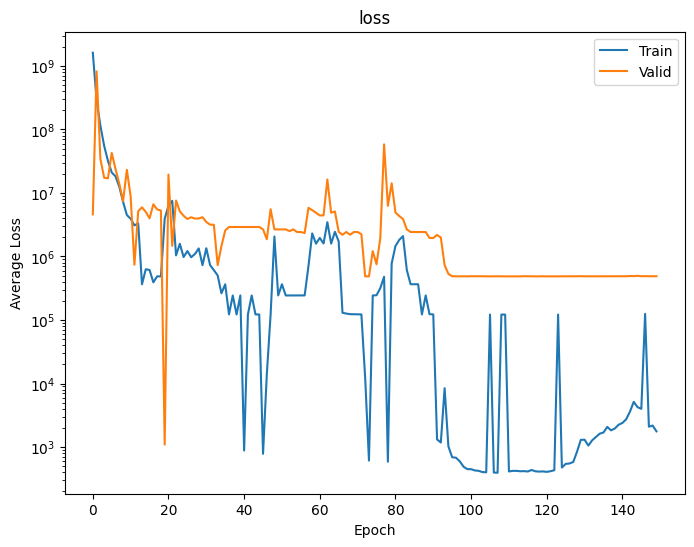

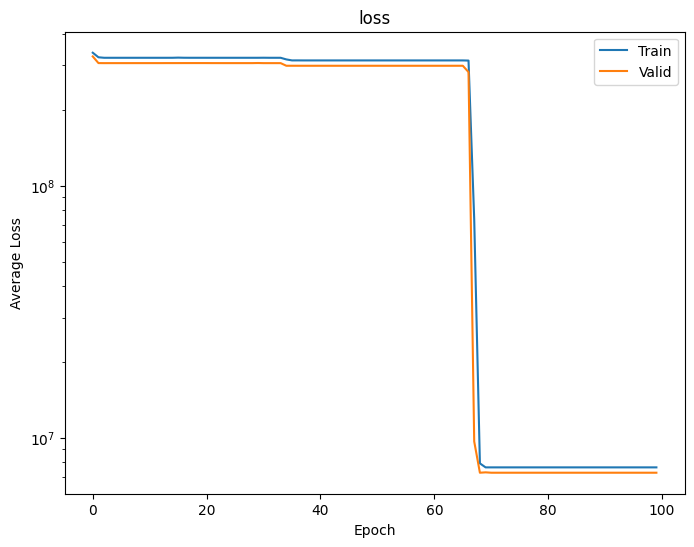

In [14]:
encoder_path=f"{model_save_path}/encoder_30.pth"
decoder_path=f"{model_save_path}/decoder_30.pth"
torch.save(encoder.state_dict(), encoder_path)
torch.save(decoder.state_dict(), decoder_path)

encoder=load_encoder(encoder_path, encoded_space_dim)
# decoder=load_decoder(decoder_path, 64)
# encoder.to(device)

/home/chuangyan/Data-Side-of-the-Moon/code/encoder.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.devic

In [15]:
from tqdm import tqdm
from encoder import encode_data

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].to(device)
    label = sample[1]
    
    # Encode image
    # encoder.eval()
    # with torch.no_grad():
    #     encoded_img  = encoder(img)
    # Append to list
    # encoded_img = encoded_img.flatten().cpu().numpy()
    
    # print(img.shape)
    
    encoded_img = encode_data(encoder, img)
    
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples.to_csv(f"{csv_save_path}/gtzan_encoded.csv", index=False)
encoded_samples

  0%|          | 0/300 [00:00<?, ?it/s]/home/chuangyan/Data-Side-of-the-Moon/code/encoder.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrogram_tensor = torch.tensor(spectrogram, dtype=torch.float32).to(device)
100%|██████████| 300/300 [00:03<00:00, 82.71it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,...,Enc. Variable 119,Enc. Variable 120,Enc. Variable 121,Enc. Variable 122,Enc. Variable 123,Enc. Variable 124,Enc. Variable 125,Enc. Variable 126,Enc. Variable 127,label
0,0.345390,-0.005637,0.923039,0.418122,-1.742137,-0.381228,0.289479,0.765170,0.200921,-0.384657,...,0.768927,-0.022927,-0.151695,2.836699,-0.356846,0.194362,0.000959,0.662777,-0.199394,blues
1,0.126470,-0.238933,-1.050993,-0.131913,-0.209398,-0.109728,0.324970,-0.393268,0.346487,-0.667818,...,0.327983,-0.275335,0.057897,0.107502,0.448982,0.321547,-0.151166,1.442876,-0.368826,blues
2,0.082651,-0.128346,-0.554795,-0.406703,-1.616051,0.030091,0.440601,-0.877780,0.199454,-0.362227,...,0.456742,0.172732,-0.774510,0.043795,-1.899760,-0.116258,0.165759,0.742109,-0.457643,blues
3,0.011681,-0.231186,-0.548878,-0.246857,0.666298,-0.075255,0.099109,0.263545,0.170002,-0.438289,...,0.510038,-0.137260,1.586607,-1.139841,0.371217,0.948499,0.215188,0.852027,-0.090959,blues
4,0.463365,0.093050,1.167623,-0.129712,0.787147,-0.221161,0.577023,0.612516,0.226075,-1.129897,...,0.231240,-0.140034,1.890233,1.092526,-0.591503,1.414019,0.025103,-1.209640,-0.435811,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.148488,-0.257874,-0.311337,3.391179,0.852805,-0.310987,0.083297,-0.486185,0.064605,-0.468686,...,0.717688,-0.092778,-0.008105,0.124334,-1.957255,0.405728,0.181035,0.759446,-0.184395,jazz
296,-0.171524,-0.205439,-0.065676,-0.324058,0.883395,0.057566,-0.075043,1.594994,-0.128076,-0.065893,...,0.315401,0.069273,-0.473628,-0.376676,0.178296,-1.683720,0.028610,0.175605,-0.210638,jazz
297,0.228964,-0.053024,-0.009363,-0.677147,1.748841,0.065185,-0.011680,-0.740164,0.010875,-0.387429,...,0.457999,-0.168256,1.400053,0.259188,-1.163264,-0.829112,-0.239741,-1.627020,-0.012906,jazz
298,0.400592,-0.154354,-0.227666,0.101206,0.881625,-0.179422,-0.135971,0.208639,-0.063897,-0.672066,...,0.583028,-0.121018,0.307985,0.150034,0.352676,0.558625,0.217502,0.749485,-0.271371,jazz
